##Instalación de librerias 

In [ ]:
!pip install PyDrive

In [ ]:
pip install --upgrade category_encoders

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import files

##Información del Data set

In [ ]:
id_train_labels = '1o8fEed65R8219m5iOJoZgvHXaTGwWE4H'
id_train_values = "1RCoa3FWbpcHVC6imhaQQFQEAWNW0qkh0" 
id_test_values = '1xBGPZbt3BYxe1OOYGMJuGnXe_pEqFZ1a'
id_submission_format = "1ei8BhsAAhZpZ8sRqEOVGl12y0JAPdXGV"

downloaded_train_labels = drive.CreateFile({'id': id_train_labels})
downloaded_train_values = drive.CreateFile({'id': id_train_values})
downloaded_test_values = drive.CreateFile({'id': id_test_values})
downloaded_submission_format = drive.CreateFile({'id': id_submission_format})

downloaded_train_labels.GetContentFile('train_labels.csv')
downloaded_train_values.GetContentFile('train_values.csv')
downloaded_test_values.GetContentFile('test_values.csv')
downloaded_submission_format.GetContentFile('submission_format.csv')

In [ ]:

train_values = pd.read_csv('train_values.csv', dtype={
    'building_id': 'int64', 'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32',
    'land_surface_condition': 'category', 'foundation_type': 'category',
    'roof_type': 'category', 'ground_floor_type': 'category', 'other_floor_type': 'category',
    'position': 'category', 'plan_configuration': 'category', 'has_superstructure_adobe_mud': 'int8',
    'has_superstructure_mud_mortar_stone': 'int8', 'has_superstructure_stone_flag': 'int8',
    'has_superstructure_cement_mortar_stone': 'int8', 'has_superstructure_mud_mortar_brick': 'int8',
    'has_superstructure_cement_mortar_brick': 'int8', 'has_superstructure_timber': 'int8',
    'has_superstructure_bamboo': 'int8', 'has_superstructure_rc_non_engineered': 'int8',
    'has_superstructure_rc_engineered': 'int8', 'has_superstructure_other': 'int8',
    'has_superstructure_other': 'int8', 'legal_ownership_status': 'category',
    'has_secondary_use': 'bool', 'has_secondary_use_agriculture': 'bool',
    'has_secondary_use_hotel': 'bool', 'has_secondary_use_rental': 'bool',
    'has_secondary_use_institution': 'bool', 'has_secondary_use_school': 'bool',
    'has_secondary_use_industry': 'bool', 'has_secondary_use_health_post': 'bool',
    'has_secondary_use_gov_office': 'bool', 'has_secondary_use_use_police': 'bool',
    'has_secondary_use_other': 'bool', 'count_families': 'int8'
})
train_labels = pd.read_csv('train_labels.csv', dtype={
    'damage_grade': 'int16'
})

test_values = pd.read_csv('test_values.csv', dtype={
  'building_id': 'int64', 'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32',
    'land_surface_condition': 'category', 'foundation_type': 'category',
    'roof_type': 'category', 'ground_floor_type': 'category', 'other_floor_type': 'category',
    'position': 'category', 'plan_configuration': 'category', 'has_superstructure_adobe_mud': 'int8',
    'has_superstructure_mud_mortar_stone': 'int8', 'has_superstructure_stone_flag': 'int8',
    'has_superstructure_cement_mortar_stone': 'int8', 'has_superstructure_mud_mortar_brick': 'int8',
    'has_superstructure_cement_mortar_brick': 'int8', 'has_superstructure_timber': 'int8',
    'has_superstructure_bamboo': 'int8', 'has_superstructure_rc_non_engineered': 'int8',
    'has_superstructure_rc_engineered': 'int8', 'has_superstructure_other': 'int8',
    'has_superstructure_other': 'int8', 'legal_ownership_status': 'category',
    'has_secondary_use': 'bool', 'has_secondary_use_agriculture': 'bool',
    'has_secondary_use_hotel': 'bool', 'has_secondary_use_rental': 'bool',
    'has_secondary_use_institution': 'bool', 'has_secondary_use_school': 'bool',
    'has_secondary_use_industry': 'bool', 'has_secondary_use_health_post': 'bool',
    'has_secondary_use_gov_office': 'bool', 'has_secondary_use_use_police': 'bool',
    'has_secondary_use_other': 'bool', 'count_families': 'int8'

})

In [ ]:
labels_and_values = pd.merge(
    train_labels, train_values, how='inner', on='building_id')

In [ ]:
labels_and_values.head(5)

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False


Agregamos Volumen


In [ ]:
labels_and_values['volume_percentage'] = labels_and_values['height_percentage'] * labels_and_values['area_percentage']

In [ ]:
test_values['volume_percentage'] = test_values['height_percentage'] * test_values['area_percentage']

Land surface, plan_configuration y foundation_type con one hot encoding

In [ ]:

labels_and_values = pd.get_dummies(labels_and_values, columns=['plan_configuration'],drop_first=True)
labels_and_values = pd.get_dummies(labels_and_values, columns=['land_surface_condition'], drop_first=True)
labels_and_values = pd.get_dummies(labels_and_values, columns=['foundation_type'], drop_first=True)

In [ ]:

test_values = pd.get_dummies(test_values, columns=['plan_configuration'],drop_first=True)
test_values = pd.get_dummies(test_values, columns=['land_surface_condition'], drop_first=True)
test_values = pd.get_dummies(test_values, columns=['foundation_type'], drop_first=True)

Tratamiento de age = 995

In [ ]:
labels_and_values = labels_and_values[labels_and_values['age']!=995]

In [ ]:
damage_prediction = labels_and_values['damage_grade']

##Separación de la variable a predecir y los features que nos interesan

**Dejamos solo las columnas que nos interesan, sin damage grade xq es lo que queremos predecir**

In [ ]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 52 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   building_id                             86868 non-null  int64   
 1   geo_level_1_id                          86868 non-null  int64   
 2   geo_level_2_id                          86868 non-null  int64   
 3   geo_level_3_id                          86868 non-null  int64   
 4   count_floors_pre_eq                     86868 non-null  int8    
 5   age                                     86868 non-null  int32   
 6   area_percentage                         86868 non-null  int32   
 7   height_percentage                       86868 non-null  int32   
 8   roof_type                               86868 non-null  category
 9   ground_floor_type                       86868 non-null  category
 10  other_floor_type                        86868 

In [ ]:


features = labels_and_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id","volume_percentage","area_percentage","age","height_percentage","land_surface_condition_o","land_surface_condition_t",'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag','has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 'has_superstructure_other']]


In [ ]:
test_values = test_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id","volume_percentage","area_percentage","age","height_percentage","land_surface_condition_o","land_surface_condition_t",'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag','has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 'has_superstructure_other']]

In [ ]:
test_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,volume_percentage,area_percentage,age,height_percentage,land_surface_condition_o,land_surface_condition_t,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
0,17,596,11307,42,7,20,6,0,1,0,1,0,0,0,0,0,0,0,0,0
1,6,141,11987,65,13,25,5,0,1,0,1,0,0,0,0,0,0,0,0,0
2,22,19,10044,20,4,5,5,0,1,0,1,0,0,0,0,0,0,0,0,0
3,26,39,633,57,19,0,3,0,1,0,0,0,0,0,1,0,0,0,0,0
4,17,289,7970,56,8,15,7,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,4,605,3623,120,20,70,6,0,1,0,1,0,0,0,0,1,0,0,0,0
86864,10,1407,11907,42,6,25,7,0,0,1,1,1,0,0,0,0,0,0,0,0
86865,22,1136,7712,9,3,50,3,0,1,0,1,0,0,0,0,1,0,0,0,0
86866,6,1041,912,45,9,5,5,0,1,1,1,0,0,0,0,0,0,0,0,0


##Creación del set de entrenamiento y test

**Dividimos train y test**


El parametro test_size es 0.2 ya que consideramos del data set el 20% para test y el 80% para el set de train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, damage_prediction, test_size=0.2, random_state=45)

##KFOLD CROSS VALIDATION

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
ftwo_scorer = make_scorer(f1_score,average='micro')

In [ ]:
#scores = cross_val_score(model, X_train, y_train, scoring=ftwo_scorer)

In [ ]:
#scores

##XGBoost


In [ ]:
XParametros = {'learning_rate' : [0.1],
               'max_depth' : [5,8,7,9,10],
               'n_estimators' : [100,130,170],
               }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
model = XGBClassifier()


In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Importancia de los features para el modelo XGBoost

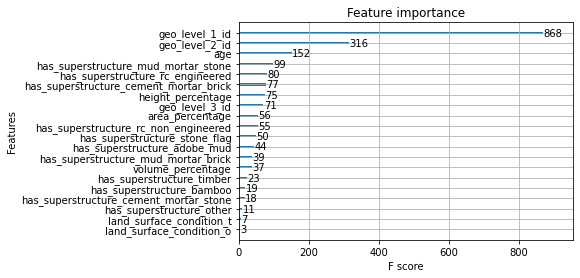

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(model, ax=plt.gca())

**Predicciones**

In [ ]:
predicciones = model.predict(X_test)

**Precision**

In [ ]:
f1_score(predicciones, y_test, average='micro')

0.6667631117026407

In [ ]:
pred_train = model.predict(test_values)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

In [ ]:
my_submission = pd.DataFrame(data = pred_train,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:

#files.download("submission.csv")